In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check pyrhon version
torch.__version__

'2.1.0+cu121'

In [3]:
#Create 'known' parameters
weight =  0.7
bias=0.3

#Create data
start = 0
end = 1
step =  0.02
X =  torch.arange(start,end,step).unsqueeze(dim=1)
y=weight * X + bias

X[:10],y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [5]:
len(X),len(y)

(50, 50)

#splitting data into training and test data set


In [4]:
#Create a train/test split
train_split=int(0.8 * len(X))
X_train,y_train= X[:train_split],y[:train_split]
X_test,y_test= X[train_split:],y[train_split:]

len(X_train),len(y_train),len(X_test),len(y_test)

(40, 40, 10, 10)

Visualize,visualize,visualze!


In [5]:
def plot_predictions(train_data=X_train,train_labels=y_train,test_data=X_test,test_labels=y_test,predictions=None):
#plot training data, test data and compare predictions
  plt.figure(figsize=(10,7))

#Plot training data in blue
  plt.scatter(train_data,train_labels,c="b" , s=4, label="Training data")

#Plot test data in green
  plt.scatter(test_data, test_labels, c="g" , s=4, label="Testing data")

#Are there predictions?
  if predictions is not None:
  #Plot the predictions if they exist
    plt.scatter(test_data,predictions,c="r",s=4,label="Predictions")

  #Show the legend
  plt.legend(prop={"size": 14});

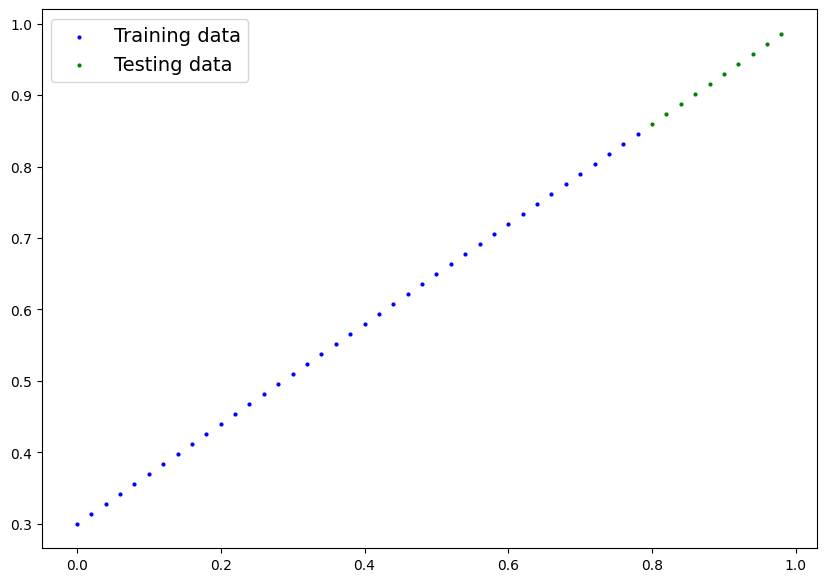

In [6]:
plot_predictions();

##2. Build Model
Our first PyTorch model!!


In [7]:
from torch import nn

#Create a linear regression model class
class LinearRegressionModel(nn.Module): # <-- almost everything in PyTorch inherits from nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, # <-start with a random weight and try to adjust it to the ideal weight
                                            requires_grad=True, # <- can thhhis parameter be updated via gradient descent?
                                            dtype=torch.float)) #<- PyTorch loves the datatype torch.float32

    self.bias=nn.Parameter(torch.randn(1,requires_grad=True,dtype=torch.float))
  #FORWARD METHOD TO DEFINE THE COMPUTATION IN MODEL
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
    return self.weights * x + self.bias #this is linear regression formula

 ### PyTorch model building essentials

 * torch.nn - contains all of the buildings for computational graphs(a neural network can be  considered a computational graph)
 * torch.nn.Parameter -  what parameter should our model tr and learn, often a PyTorch layer from torch.nn will set these for us
 * torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite forward()
 * torch.optim - this is where the optimizers in PyTorch live, they will help with gradient descent.
 * def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation

In [42]:
#Create a random seed
torch.manual_seed(42)

#Create an instance of the model(this is the subclass of nn.Module)
model_0 = LinearRegressionModel()

#Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [43]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [30]:
weight,bias

(0.7, 0.3)

### Making prediction using 'torch.inference_mode()'

In [31]:
#Make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [32]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [44]:
# Setup a loss function
loss_fn = nn.L1Loss()

#Setup an optimizer (SGD)
optimizer =  torch.optim.SGD(params=model_0.parameters(),lr=0.01)

### Building a training loop in PyTorch

things we need in a training loop:
0. Loop through the data
1. Forward pass ( this involves data moving through our model's 'forward()' functions) to make predictions on data - also called forward propagation.
2. Calculate the loss(Compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model w.r.t. the loss(***backpropagation***)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss(***gradient descent***)

In [45]:
torch.manual_seed(42)

#An epoch is one loop through the data...
epochs = 200

#Track different values
epoch_count = []
loss_values = []
test_loss_values = []

###Training
# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that requires gradient to require gradients)

  #1. Forward pass
  y_pred = model_0(X_train)

  #2. Calculate the loss
  loss = loss_fn(y_pred, y_train)
  print(f"Loss: {loss}")

  #3. Optimizer zero grad
  optimizer.zero_grad()

  #4. Perform Backpropagation
  loss.backward()

  #5. Step the optimizer (gradient descent)
  optimizer.step() # by default how the optimizer changes will accumulate through the loop so.....  we have to zero them above in step 3 for the next iteration of the loop

  ###Testing
  model_0.eval() #turns off different settings in thee model not needed for evaluation/testing
  with torch.inference_mode(): #turns of gradient tracking and few more things behind the scene
  # with torch.no_grad():
      #1. Do the forward pass
      test_pred = model_0(X_test)

      #2 Calculate the loss
      test_loss = loss_fn(test_pred, y_test)
  # Print out what's happening
  if epoch % 10 == 0:
     epoch_count.append(epoch)
     loss_values.append(loss.item())
     test_loss_values.append(test_loss.item())
     print(f"Epoch : {epoch} | Loss: {loss} | Test loss: {test_loss}")

     # Print out model state_dict()
     print(model_0.state_dict())


Loss: 0.31288138031959534
Epoch : 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Loss: 0.3013603389263153
Loss: 0.28983935713768005
Loss: 0.2783183455467224
Loss: 0.26679736375808716
Loss: 0.2552763521671295
Loss: 0.24375534057617188
Loss: 0.23223432898521423
Loss: 0.22071333229541779
Loss: 0.20919232070446014
Loss: 0.1976713240146637
Epoch : 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Loss: 0.18615034222602844
Loss: 0.1746293306350708
Loss: 0.16310831904411316
Loss: 0.1515873372554779
Loss: 0.14006635546684265
Loss: 0.1285453587770462
Loss: 0.11702437698841095
Loss: 0.1060912236571312
Loss: 0.09681284427642822
Loss: 0.08908725529909134
Epoch : 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Loss: 0.08227583020925522
Loss

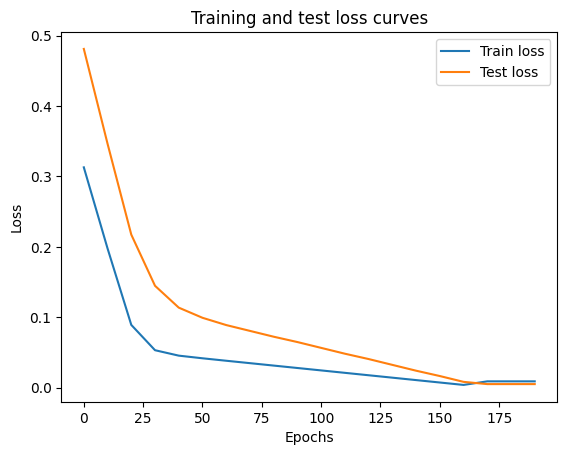

In [46]:
# import numpy as np
# np.array(torch.tensor(loss_values).numpy()),test_loss_values
#Plot the loss curves
plt.plot(epoch_count,np.array(loss_values), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [19]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

In [20]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6951])), ('bias', tensor([0.2993]))])

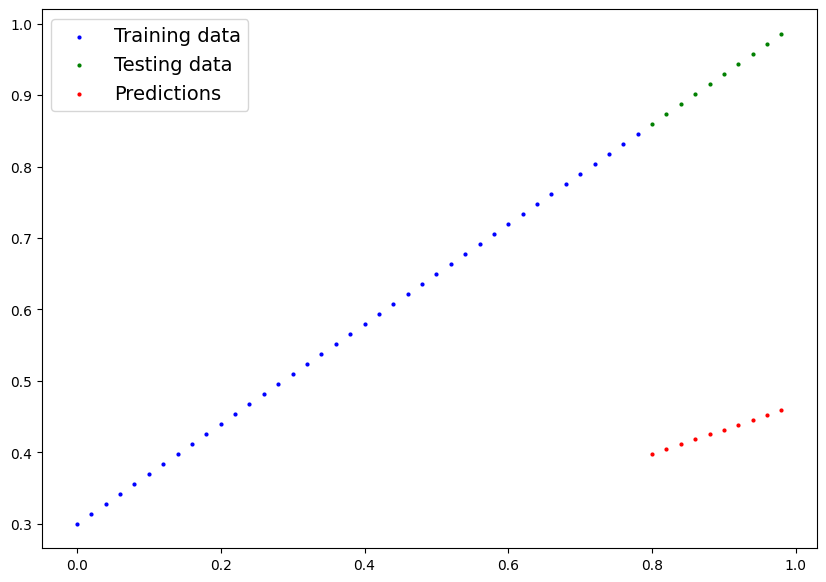

In [21]:
plot_predictions(predictions=y_preds);

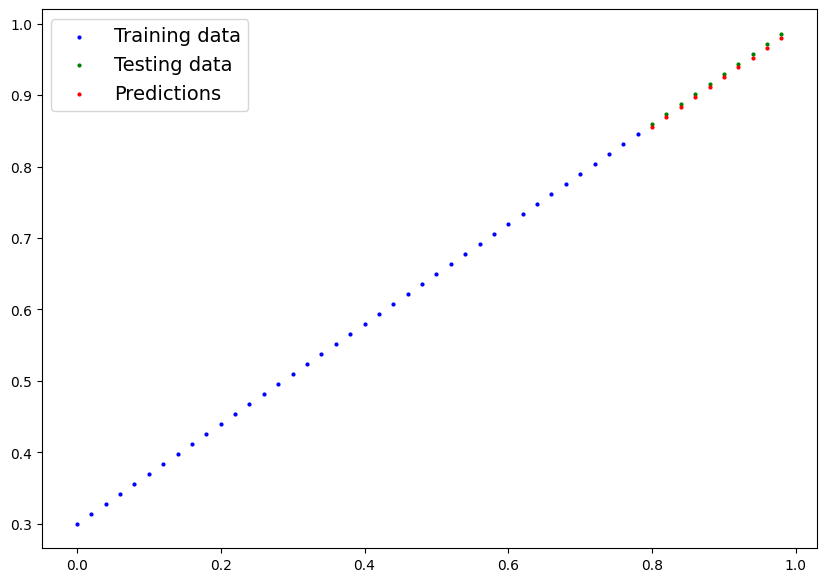

In [22]:
plot_predictions(predictions=y_preds_new);